In [1]:
from pathlib import Path
import os
import json
import sys
import optuna
from optuna.samplers import TPESampler
from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import ProgressBarCallback
import numpy as np
import torch
import random
import yaml
import pandas as pd
import datetime
path_to_src = Path(Path(os.getcwd()).parent, 'src')
sys.path.append(str(path_to_src))
from enviroment import StockTradingEnvDSR
from agents import LinearFeatureExtractor, RNNFeatureExtractor, LSTMExtractor, MLPFeatureExtractor
from utils import get_data, get_scaled_data_new, get_time_data_new, prepare_aligned_data, daily_portfolio_return, statistics_calc
import warnings
warnings.filterwarnings('ignore')

In [2]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "MLP",
    "window_size": 60,
    "price_column": 3,
    "num_actions": 11,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 1000000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2022-01-11"),
    "val_period": ("2022-01-11", "2025-03-19"),
    "test_period": None  # Для одиночного режима
}


In [3]:
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def create_env(data, scaled_data, time_data, config, mode='train', n_envs=1, period_override=None):
    """Создает окружение с возможностью переопределения периодов"""
    if period_override:
        start, end = period_override
    else:
        if mode == 'train':
            start, end = config.get("train_period", (None, None))
        elif mode == 'val':
            start, end = config.get("val_period", (None, None))
        elif mode == 'test':
            start, end = config.get("test_period", (None, None))
    
    if start is None or end is None:
        raise ValueError(f"Для режима {mode} не заданы периоды")
    
    mask = (data.index >= start) & (data.index <= end)
    
    # Применяем маску
    data_segment = data[mask]
    scaled_segment = scaled_data[mask]
    time_segment = time_data[mask]
    
    env_kwargs = {
        "data": data_segment[['open', 'high', 'low', 'close']].values.astype(np.float32),
        "scaled_data": scaled_segment.values.astype(np.float32),
        "time_data": time_segment.values.astype(np.float32),
        "window_size": config["window_size"],
        "price_column": config["price_column"],
        "num_actions": config["num_actions"], 
        "timestamps": data_segment.index.values
    }
    
    if n_envs > 1:
        return make_vec_env(
            lambda: StockTradingEnvDSR(**env_kwargs),
            n_envs=n_envs,
            vec_env_cls=SubprocVecEnv,
            seed=config["seed"]
        )
    else:
        return DummyVecEnv([lambda: StockTradingEnvDSR(**env_kwargs)])

def get_model_config(model_type):
    """Возвращает policy_kwargs для выбранного экстрактора"""
    base_config = {
        "MLP": {
            "features_extractor_class": MLPFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": 64,
                "hidden_layers": [256, 128],
                "dropout": 0.2
            }
        },
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": 32
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": 64,
                "hidden_size": 128
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": 64,
                "hidden_size": 128
            }
        }
    }
    return base_config.get(model_type, base_config["Linear"])

In [4]:
def train_single_model(config, trial=None):
    set_seeds(config["seed"])
    
    raw_data, scaled_data, time_data, _ = prepare_aligned_data(
        config["ticker"], config
    )
    
    # Создаем окружения с использованием периодов из конфига
    env_train = create_env(
        raw_data, scaled_data, time_data, config,
        mode='train', n_envs=5
    )
    env_val = create_env(
        raw_data, scaled_data, time_data, config,
        mode='val', n_envs=1
    )

    # Получаем конфиг экстрактора
    policy_kwargs = get_model_config(config["model_type"])
    
    # Обновляем параметры PPO
    ppo_params = config["ppo_params"].copy()
    ppo_params["policy_kwargs"] = policy_kwargs
    
    model = PPO(
        "MlpPolicy",
        env_train,
        verbose=1,
        **ppo_params
    )
    
    model.learn(total_timesteps=config["total_timesteps"], log_interval=100, callback=ProgressBarCallback())
    
    returns, b_h_ret = daily_portfolio_return(env_val, model)
    metrics = statistics_calc(returns, b_h_ret, plot=True, mode='validation')
    
    return metrics, returns, b_h_ret, model

In [5]:
def sliding_window_training(config):
    set_seeds(config["seed"])
    window_cfg = config["sliding_window_config"]
    best_agent = None
    all_results = []

    raw_data, scaled_data, time_data, _ = prepare_aligned_data(
        config["ticker"], config
    )
    start_year = window_cfg["start_year"]
    n_windows = window_cfg["n_windows"]
    
    for window_idx in range(n_windows):
        current_year = start_year + window_idx
        print(f"\nОкно {window_idx+1}/{n_windows} (Год: {current_year})")
        
        # Расчет периодов для текущего окна
        train_start = datetime.datetime(current_year, 1, 1)
        train_end = train_start + datetime.timedelta(days=365 * window_cfg["train_years"])
        val_start = train_end
        val_end = val_start + datetime.timedelta(days=365 * window_cfg["val_years"])
        test_start = val_end
        test_end = test_start + datetime.timedelta(days=365 * window_cfg["test_years"])
        
        # Создание окружений
        env_train = create_env(
            raw_data, scaled_data, time_data, config, 
            n_envs=window_cfg["n_envs"],
            period_override=(train_start, train_end)
        )
        
        env_val = create_env(
            raw_data, scaled_data, time_data, config,
            mode='val', n_envs=1,
            period_override=(val_start, val_end)
        )
        
        best_agent_val = None
        best_val_reward = -np.inf
        
        for agent_idx in range(window_cfg["n_agents"]):
            print(f"Обучение агента {agent_idx+1}/{window_cfg['n_agents']}")
            set_seeds(config["seed"] + agent_idx)
            
            # Получаем конфиг экстрактора
            policy_kwargs = get_model_config(config["model_type"])
            
            # Инициализация модели
            if best_agent and window_idx > 0:
                model = PPO(
                    "MlpPolicy",
                    env_train,
                    **config["ppo_params"],
                    policy_kwargs=policy_kwargs
                )
                model.set_parameters(best_agent.get_parameters())
            else:
                model = PPO(
                    "MlpPolicy",
                    env_train,
                    **config["ppo_params"],
                    policy_kwargs=policy_kwargs
                )
            
            # Обучение
            model.learn(total_timesteps=config["total_timesteps"], callback=ProgressBarCallback())
            
            # Оценка
            mean_reward, _ = evaluate_policy(
                model, env_val, n_eval_episodes=1, deterministic=True
            )
            print(f"Агент {agent_idx+1} Средняя награда: {mean_reward:.4f}")
            
            if mean_reward > best_val_reward:
                best_val_reward = mean_reward
                best_agent_val = model
        
        # Тестирование лучшего агента
        env_test = create_env(
            raw_data, scaled_data, time_data, config,
            mode='test', n_envs=1,
            period_override=(test_start, test_end)
        )
        
        returns, b_h_ret = daily_portfolio_return(env_test, best_agent_val)
        metrics = statistics_calc(
            returns, b_h_ret, 
            name=f"Window_{window_idx}", 
            plot=True,
            mode='test',
            ticker=config["ticker"]
        )
        
        all_results.append(metrics)
        best_agent = best_agent_val  # Для следующего окна
        
        # Очистка
        del env_train, env_val, env_test
        torch.cuda.empty_cache()
    
    return pd.concat(all_results)

In [6]:
set_seeds(CONFIG["seed"])
Path("save", "models").mkdir(exist_ok=True)
Path("save", "logs").mkdir(exist_ok=True)

Режим обучения: единый прогон
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_20


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.75e+03   |
|    ep_rew_mean          | -1.38      |
| time/                   |            |
|    fps                  | 1626       |
|    iterations           | 100        |
|    time_elapsed         | 232        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.23987325 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.5       |
|    explained_variance   | 0.046      |
|    learning_rate        | 0.0003     |
|    loss                 | 92.1       |
|    n_updates            | 1584       |
|    policy_gradient_loss | 0.039      |
|    value_loss           | 262        |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.75e+03   |
|    ep_rew_mean

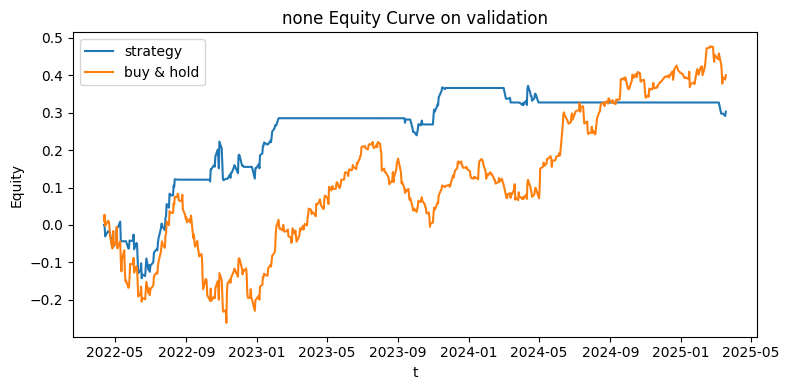

Metrics on validation:
Sharpe ratio: 1.029463817842437, annual return: 0.19275493976457983, volatility: 0.1872381879030562


In [23]:
if CONFIG["training_mode"] == "single":
    print("Режим обучения: единый прогон")
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)
elif CONFIG["training_mode"] == "sliding_window":
    print("Режим обучения: скользящие окна")
    results = sliding_window_training(CONFIG)
    print(results)
else:
    raise ValueError("Неизвестный режим обучения")

In [13]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 1000000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None  # Для одиночного режима
}


Режим обучения: единый прогон
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_24


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.97e+03   |
|    ep_rew_mean          | 64.4       |
| time/                   |            |
|    fps                  | 2531       |
|    iterations           | 100        |
|    time_elapsed         | 149        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.09910954 |
|    clip_fraction        | 0.153      |
|    clip_range           | 0.25       |
|    entropy_loss         | -0.744     |
|    explained_variance   | 0.828      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.371      |
|    n_updates            | 1584       |
|    policy_gradient_loss | 0.00546    |
|    value_loss           | 1.03       |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.97e+03    |
|    ep_rew_m

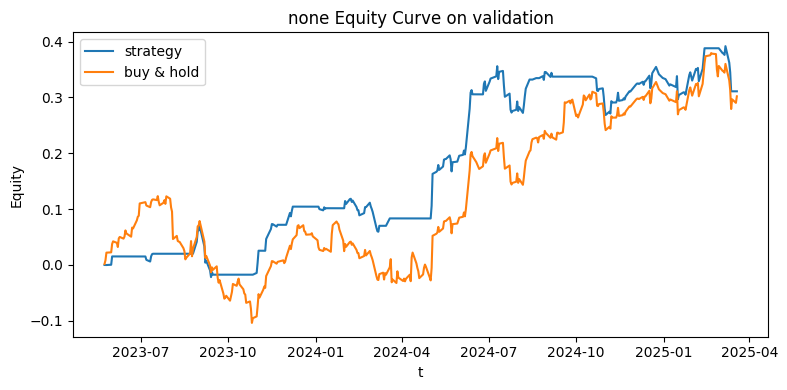

Metrics on validation:
Sharpe ratio: 1.62953339497471, annual return: 0.32169023980256967, volatility: 0.1974124867858644


In [14]:
if CONFIG["training_mode"] == "single":
    print("Режим обучения: единый прогон")
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)
elif CONFIG["training_mode"] == "sliding_window":
    print("Режим обучения: скользящие окна")
    results = sliding_window_training(CONFIG)
    print(results)
else:
    raise ValueError("Неизвестный режим обучения")

In [13]:
CONFIG = {
    "ticker": "AMZN",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 500000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None  # Для одиночного режима
}


Режим обучения: единый прогон
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_31


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.97e+03   |
|    ep_rew_mean          | 27.6       |
| time/                   |            |
|    fps                  | 2434       |
|    iterations           | 100        |
|    time_elapsed         | 155        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.17011434 |
|    clip_fraction        | 0.19       |
|    clip_range           | 0.25       |
|    entropy_loss         | -0.693     |
|    explained_variance   | 0.601      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.206      |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.00233   |
|    value_loss           | 0.958      |
----------------------------------------


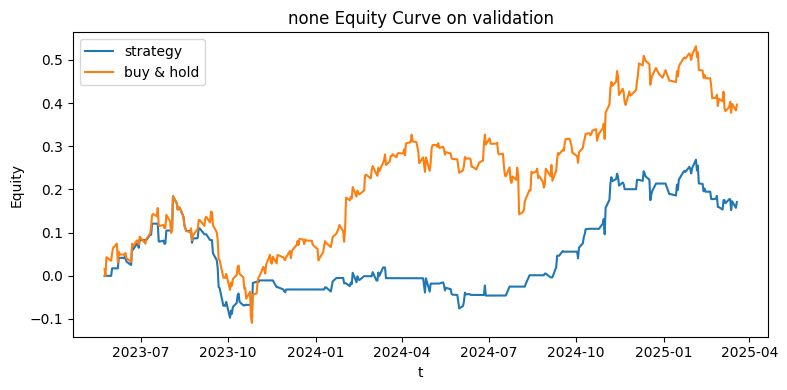

Metrics on validation:
Sharpe ratio: 0.689597249155816, annual return: 0.17687164304739406, volatility: 0.25648542430225024


In [14]:
if CONFIG["training_mode"] == "single":
    print("Режим обучения: единый прогон")
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)
elif CONFIG["training_mode"] == "sliding_window":
    print("Режим обучения: скользящие окна")
    results = sliding_window_training(CONFIG)
    print(results)
else:
    raise ValueError("Неизвестный режим обучения")

In [15]:
CONFIG = {
    "ticker": "MSFT",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 500000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None  # Для одиночного режима
}


Режим обучения: единый прогон
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_32


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.97e+03   |
|    ep_rew_mean          | -12.1      |
| time/                   |            |
|    fps                  | 2344       |
|    iterations           | 100        |
|    time_elapsed         | 161        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.06543999 |
|    clip_fraction        | 0.117      |
|    clip_range           | 0.25       |
|    entropy_loss         | -0.871     |
|    explained_variance   | 0.362      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.591      |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.000764  |
|    value_loss           | 1.76       |
----------------------------------------


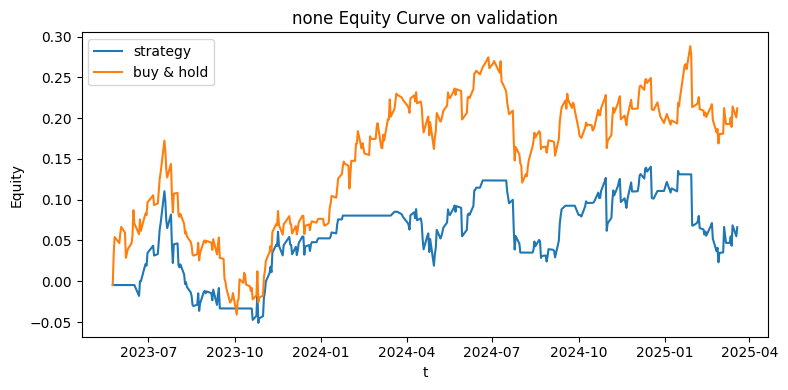

Metrics on validation:
Sharpe ratio: 0.3100888575268055, annual return: 0.06856016035106262, volatility: 0.22109843255214667


In [16]:
if CONFIG["training_mode"] == "single":
    print("Режим обучения: единый прогон")
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)
elif CONFIG["training_mode"] == "sliding_window":
    print("Режим обучения: скользящие окна")
    results = sliding_window_training(CONFIG)
    print(results)
else:
    raise ValueError("Неизвестный режим обучения")

# Тест последовательного обучения агентов (sliding_window)

In [7]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "sliding_window",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 500000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None  # Для одиночного режима
}


Режим обучения: скользящие окна
Shape of data: (4040, 6) 2010-01-04 00:00:00

Окно 1/5 (Год: 2010)
Обучение агента 1/3


Output()

Output()

Агент 1 Средняя награда: 0.0000
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 0.0000
Обучение агента 3/3


Агент 3 Средняя награда: 62.5784


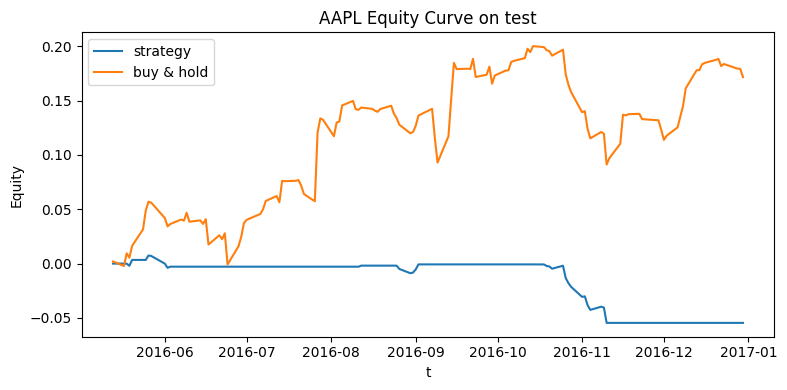

Output()

Output()

Агент 1 Средняя награда: 0.8662
Обучение агента 2/3


Output()

Агент 3 Средняя награда: 0.0000


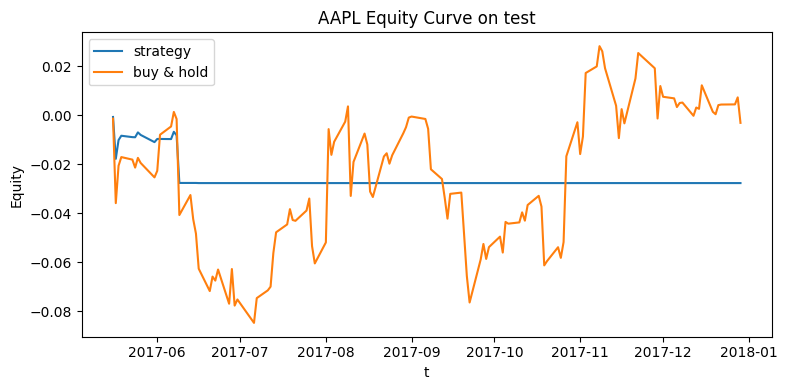

Output()

Metrics on test:
Sharpe ratio: -1.7235159547357157, annual return: -0.08078799674991399, volatility: 0.04687394771596532

Окно 3/5 (Год: 2012)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 0.0000
Обучение агента 2/3


Output()

Агент 2 Средняя награда: 0.0000
Обучение агента 3/3


Агент 3 Средняя награда: 1.9220


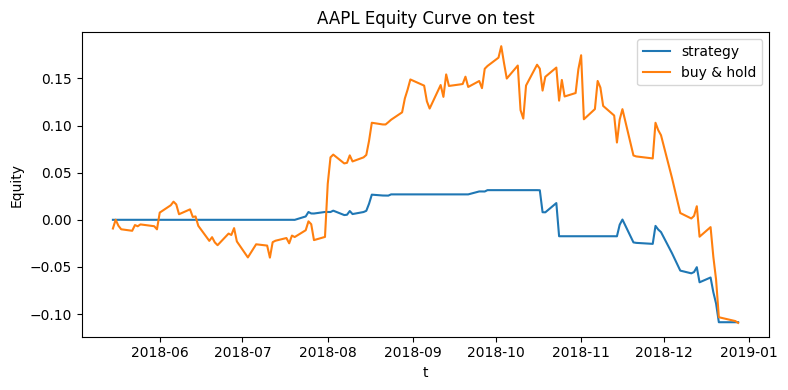

Output()

Metrics on test:
Sharpe ratio: -2.621766951602707, annual return: -0.3253776720653812, volatility: 0.12410625279507595

Окно 4/5 (Год: 2013)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: 5.3716
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -51.2075
Обучение агента 3/3


Агент 3 Средняя награда: 14.2078


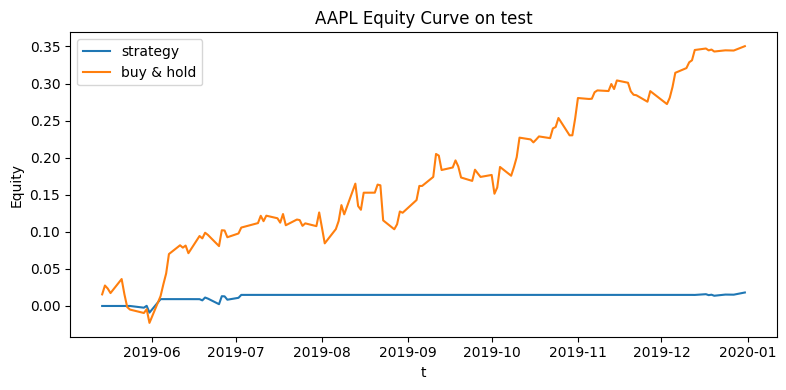

Output()

Metrics on test:
Sharpe ratio: 1.1959071515859017, annual return: 0.053136917757866824, volatility: 0.04443231039082052

Окно 5/5 (Год: 2014)
Обучение агента 1/3


Output()

Агент 1 Средняя награда: -15.2202
Обучение агента 2/3


Output()

Агент 2 Средняя награда: -13.8024
Обучение агента 3/3


Агент 3 Средняя награда: -8.3603


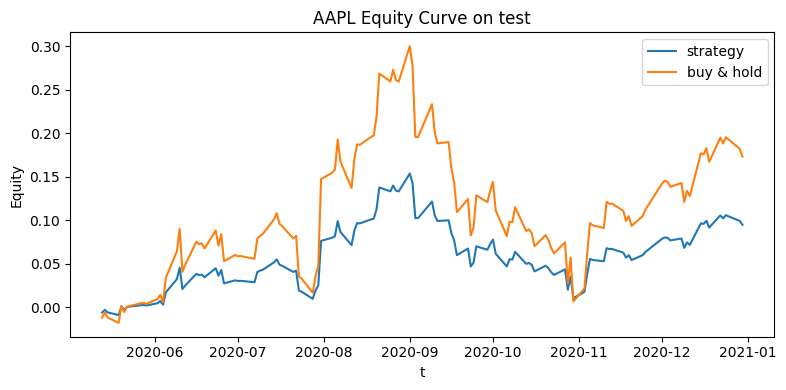

Metrics on test:
Sharpe ratio: 1.2399842370421301, annual return: 0.272451811267857, volatility: 0.21972199575517676
          Sharpe ratio  Annual return  Volatility
Window_0     -3.493619      -0.156792    0.044880
Window_1     -1.723516      -0.080788    0.046874
Window_2     -2.621767      -0.325378    0.124106
Window_3      1.195907       0.053137    0.044432
Window_4      1.239984       0.272452    0.219722


In [8]:
if CONFIG["training_mode"] == "single":
    print("Режим обучения: единый прогон")
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)
elif CONFIG["training_mode"] == "sliding_window":
    print("Режим обучения: скользящие окна")
    results = sliding_window_training(CONFIG)
    print(results)
else:
    raise ValueError("Неизвестный режим обучения")

# Сравнение с DQN

In [14]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 7200,  # 1 час
        "direction": "maximize"
    }
}

In [8]:
# Фиксация сидов для воспроизводимости
def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def create_env(data, scaled_data, time_data, config, mode='train'):
    """Создает окружение с синхронизированными данными"""
    train_start, train_end = config["train_period"]
    val_start, val_end = config["val_period"]
    
    # Создаем маску для выбранного периода
    if mode == 'train':
        mask = (data.index >= train_start) & (data.index <= train_end)
    else:
        mask = (data.index >= val_start) & (data.index <= val_end)
    
    # Применяем маску
    data_segment = data[mask] # исторические данные OLHC
    scaled_segment = scaled_data[mask] # признаковое описание (тех индикаторы и тд)
    time_segment = time_data[mask] # временные признаки
    
    # Проверка согласованности
    assert len(data_segment) == len(scaled_segment) == len(time_segment), \
        f"Размеры не совпадают: data={len(data_segment)}, scaled={len(scaled_segment)}, time={len(time_segment)}"
    
    env_kwargs = {
        "data": data_segment[['open', 'high', 'low', 'close']].values.astype(np.float32),
        "scaled_data": scaled_segment.values.astype(np.float32),
        "time_data": time_segment.values.astype(np.float32),
        "window_size": config["window_size"],
        "price_column": config["price_column"],
        "num_actions": config["num_actions"], 
        "timestamps": data_segment.index.values
    }
    
    return make_vec_env(
        lambda: StockTradingEnvDSR(**env_kwargs),
        n_envs=1,
        vec_env_cls=DummyVecEnv
    )


# Конфигурация модели
def get_model_config(model_type, trial=None):
    """Возвращает конфигурацию для выбранного типа модели"""
    base_config = {
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("linear_dim", 16, 128) if trial else 32
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("rnn_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("rnn_hidden", 64, 512) if trial else 128
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int("lstm_dim", 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int("lstm_hidden", 64, 512) if trial else 128
            }
        }
    }
    
    return base_config.get(model_type, base_config["Linear"])  

In [9]:
def train_model(config, trial=None):
    """Обучает модель с заданной конфигурацией"""
    set_seeds(config["seed"])
    
    # Получаем синхронизированные данные
    data_array, scaled_array, time_array, full_index = prepare_aligned_data(
        config["ticker"], config
    )
    
    # Создаем окружения
    env_train = create_env(data_array, scaled_array, time_array, config, 'train')
    env_val = create_env(data_array, scaled_array, time_array, config, 'val')

    params = config["default_params"].copy()

    tb_log = params.pop("tensorboard_log")
    tb_log_path = f"save/{tb_log}/{config['model_type']}_{trial.number if trial else 'default'}"

    if trial:
        params.update({
            "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True),
            "batch_size": trial.suggest_categorical("batch_size", [32, 64, 128, 256]),
            "gamma": trial.suggest_float("gamma", 0.9, 0.999),
            "exploration_fraction": trial.suggest_float("exploration_fraction", 0.1, 0.5),
            "buffer_size": trial.suggest_int("buffer_size", 5000, 100000)
        })
    
    model_config = get_model_config(config["model_type"], trial=trial)

    model = DQN(
        "MlpPolicy",
        env_train,
        policy_kwargs=model_config,
        verbose=1,
        tensorboard_log=tb_log_path,
        #replay_buffer_kwargs=dict(optimize_memory_usage=True),
        device="auto",
        **params
    )

    print(model_config)
    model.learn(
        total_timesteps=500000,
        callback=ProgressBarCallback(),
        log_interval=100,
        tb_log_name=f"{config['model_type']}_{trial.number if trial else 'default'}"
    )
    print('Обучение завершено')
    #sharpe_ratio, returns, b_h_ret = evaluate_daily_sharpe(model, env_val)
    returns, b_h_ret = daily_portfolio_return(env_val, model)
    if not trial:
        save_path = Path("models", f"{config['ticker']}_{config['model_type']}")
        model.save(str(save_path))
    
    metrics = statistics_calc(returns, b_h_ret, plot=True, mode='val', ticker=CONFIG['ticker'])
    return metrics, returns, b_h_ret, model

def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    config["window_size"] = trial.suggest_categorical("window_size", [30, 60, 90, 120])
    config["num_actions"] = trial.suggest_categorical("num_actions", [3, 5, 11, 19])
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
    metrics, p1, p2, p3 = train_model(config, trial)
    return 0.7 * metrics["Sharpe ratio"].values[0] + 0.3 * metrics["Annual return"].values[0]

Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_79


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 2.97e+03 |
|    ep_rew_mean      | 74.2     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 874      |
|    time_elapsed     | 339      |
|    total_timesteps  | 296900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.139    |
|    n_updates        | 71724    |
----------------------------------


Обучение завершено


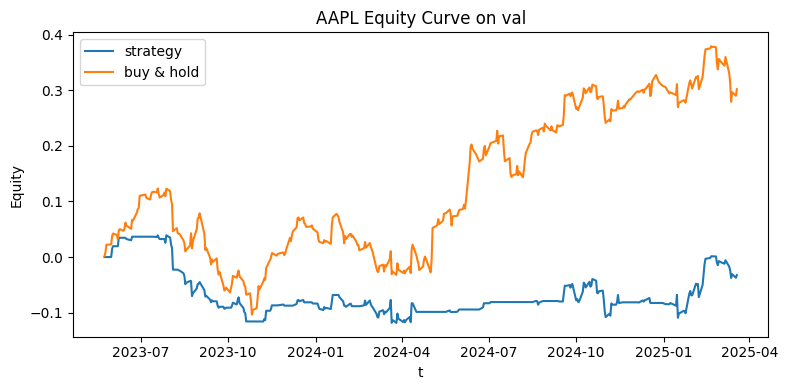

Metrics on val:
Sharpe ratio: -0.2237065076902668, annual return: -0.03369366330840066, volatility: 0.15061548122261725


In [15]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["window_size"] = best_params["window_size"]
    del best_params["window_size"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [16]:
CONFIG = {
    "ticker": "AMZN",
    "model_type": "Linear",
    "window_size": 40,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 7200,  # 1 час
        "direction": "maximize"
    }
}

Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_80


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.02e+03 |
|    ep_rew_mean      | 174      |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1070     |
|    time_elapsed     | 282      |
|    total_timesteps  | 301900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.135    |
|    n_updates        | 72974    |
----------------------------------


Обучение завершено


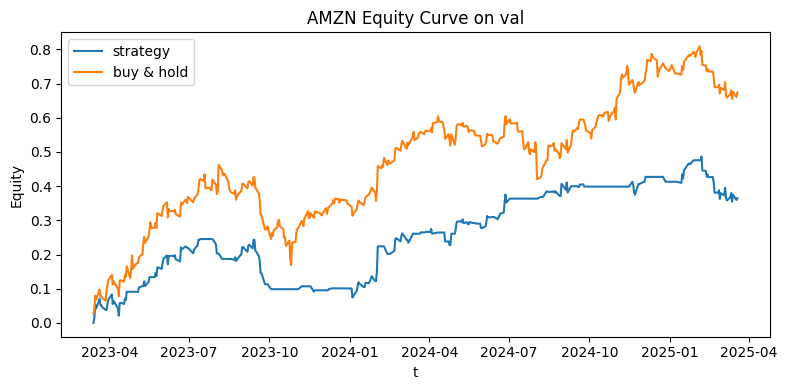

Metrics on val:
Sharpe ratio: 1.5162661374270066, annual return: 0.33929797266465617, volatility: 0.2237720438975312


In [17]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["window_size"] = best_params["window_size"]
    del best_params["window_size"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

In [18]:
CONFIG = {
    "ticker": "MSFT",
    "model_type": "Linear",
    "window_size": 40,
    "price_column": 3,
    "num_actions": 11,
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "seed": 42,
    "default_params": {
        "learning_rate": 1e-4,
        "buffer_size": 100000,
        "learning_starts": 10000,
        "batch_size": 128,
        "gamma": 0.9,
        "exploration_fraction": 0.3,
        "exploration_initial_eps": 0.9,
        "exploration_final_eps": 0.05,
        "tensorboard_log": "logs/"
    },
    "optuna": {
        "n_trials": 0,
        "timeout": 7200,  # 1 час
        "direction": "maximize"
    }
}

Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
{'features_extractor_class': <class 'agents.LinearFeatureExtractor'>, 'features_extractor_kwargs': {'features_dim': 32}}
Logging to save/logs//Linear_default\Linear_default_81


Output()

----------------------------------
| rollout/            |          |
|    ep_len_mean      | 3.02e+03 |
|    ep_rew_mean      | -64.6    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 100      |
|    fps              | 1019     |
|    time_elapsed     | 296      |
|    total_timesteps  | 301900   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0862   |
|    n_updates        | 72974    |
----------------------------------


Обучение завершено


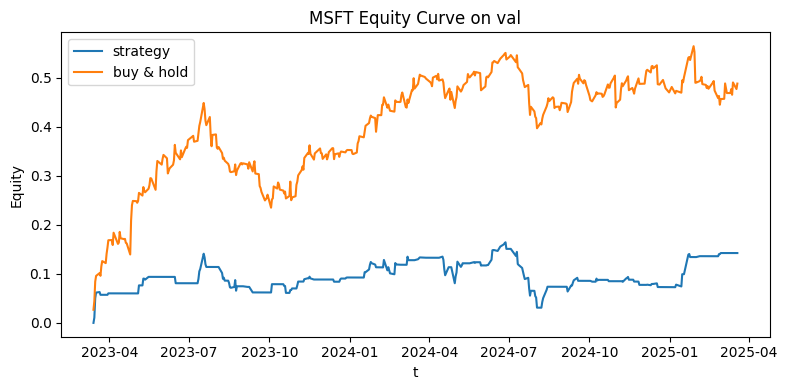

Metrics on val:
Sharpe ratio: 1.0316225940685606, annual return: 0.13226229305324894, volatility: 0.1282080227921597


In [19]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")

    # Обучение финальной модели с лучшими параметрами
    # CONFIG["model_type"] = best_params["model_type"]
    CONFIG["window_size"] = best_params["window_size"]
    del best_params["window_size"]
    CONFIG["default_params"].update({
        k: v for k, v in best_params.items() 
        if k not in ["model_type", "linear_dim", "rnn_dim", "rnn_hidden", "lstm_dim", "lstm_hidden"]
    })
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_model(CONFIG)

# Подбор гиперпараметров для PPO

In [9]:
CONFIG = {
    "ticker": "AAPL",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 5,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 500000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2023-01-11"),
    "val_period": ("2023-01-11", "2025-03-19"),
    "test_period": None,  # Для одиночного режима
    "optuna": {
        "n_trials": 10,
        "timeout": 7200,  # 1 час
        "direction": "maximize"
    }
}


In [10]:
def create_env(data, scaled_data, time_data, config, mode='train', n_envs=1, period_override=None):
    """Создает окружение с возможностью переопределения периодов"""
    if period_override:
        start, end = period_override
    else:
        if mode == 'train':
            start, end = config.get("train_period", (None, None))
        elif mode == 'val':
            start, end = config.get("val_period", (None, None))
        elif mode == 'test':
            start, end = config.get("test_period", (None, None))
    
    if start is None or end is None:
        raise ValueError(f"Для режима {mode} не заданы периоды")
    
    mask = (data.index >= start) & (data.index <= end)
    
    # Применяем маску
    data_segment = data[mask]
    scaled_segment = scaled_data[mask]
    time_segment = time_data[mask]
    
    env_kwargs = {
        "data": data_segment[['open', 'high', 'low', 'close']].values.astype(np.float32),
        "scaled_data": scaled_segment.values.astype(np.float32),
        "time_data": time_segment.values.astype(np.float32),
        "window_size": config["window_size"],
        "price_column": config["price_column"],
        "num_actions": config["num_actions"], 
        "timestamps": data_segment.index.values
    }
    
    if n_envs > 1:
        return make_vec_env(
            lambda: StockTradingEnvDSR(**env_kwargs),
            n_envs=n_envs,
            vec_env_cls=SubprocVecEnv,
            seed=config["seed"]
        )
    else:
        return DummyVecEnv([lambda: StockTradingEnvDSR(**env_kwargs)])

def get_model_config(model_type, trial=None):
    base_config = {
        "MLP": {
            "features_extractor_class": MLPFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int('linear_dim', 32, 256) if trial else 64,
                "hidden_layers": [256, 128],
                "dropout": trial.suggest_float('dropout', 0.1, 0.8) if trial else 0.1  # Добавлено условие
            }
        },
        "Linear": {
            "features_extractor_class": LinearFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int('linear_dim', 16, 128) if trial else 32,
            }
        },
        "RNN": {
            "features_extractor_class": RNNFeatureExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int('linear_dim', 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int('hidden_dim', 64, 512) if trial else 128  # Добавлено условие
            }
        },
        "LSTM": {
            "features_extractor_class": LSTMExtractor,
            "features_extractor_kwargs": {
                "features_dim": trial.suggest_int('linear_dim', 32, 256) if trial else 64,
                "hidden_size": trial.suggest_int('hidden_dim', 64, 512) if trial else 128  # Добавлено условие
            }
        }
    }
    return base_config.get(model_type, base_config["Linear"])

In [11]:
def train_single_model(config, trial=None):
    set_seeds(config["seed"])
    
    raw_data, scaled_data, time_data, _ = prepare_aligned_data(
        config["ticker"], config
    )
    
    # Создаем окружения с использованием периодов из конфига
    env_train = create_env(
        raw_data, scaled_data, time_data, config,
        mode='train', n_envs=5
    )
    env_val = create_env(
        raw_data, scaled_data, time_data, config,
        mode='val', n_envs=1
    )

    # Получаем конфиг экстрактора
    policy_kwargs = get_model_config(config["model_type"], trial=trial)
    
    # Обновляем параметры PPO
    ppo_params = config["ppo_params"].copy()
    ppo_params["policy_kwargs"] = policy_kwargs
            
    model = PPO(
        "MlpPolicy",
        env_train,
        verbose=1,
        **ppo_params
    )
    
    model.learn(total_timesteps=config["total_timesteps"], log_interval=100, callback=ProgressBarCallback())
    
    returns, b_h_ret = daily_portfolio_return(env_val, model)
    metrics = statistics_calc(returns, b_h_ret, plot=True, mode='validation')
    
    return metrics, returns, b_h_ret, model

In [12]:
def objective(trial):
    """Целевая функция для оптимизации гиперпараметров"""
    config = CONFIG.copy()
    config["window_size"] = trial.suggest_categorical("window_size", [30, 60, 90, 120, 200])
    config["num_actions"] = trial.suggest_categorical("num_actions", [3, 5, 11, 19, 27])
    config["total_timesteps"] = trial.suggest_categorical("total_timesteps", [200000, 500000, 1000000, 1500000, 2000000])
    # config["model_type"] = trial.suggest_categorical("model_type", ["Linear", "RNN", "LSTM"])
    metrics, p1, p2, p3 = train_single_model(config, trial)
    return 0.7 * metrics["Sharpe ratio"].values[0] + 0.3 * metrics["Annual return"].values[0]

[I 2025-07-14 16:36:55,911] A new study created in memory with name: no-name-a7bc6063-899c-4ca8-87f7-793d07694655


  0%|          | 0/10 [00:00<?, ?it/s]

Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_52


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3e+03      |
|    ep_rew_mean          | 13.3       |
| time/                   |            |
|    fps                  | 2483       |
|    iterations           | 100        |
|    time_elapsed         | 152        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.06587901 |
|    clip_fraction        | 0.206      |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.39      |
|    explained_variance   | 0.613      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.357      |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.024     |
|    value_loss           | 1.02       |
----------------------------------------


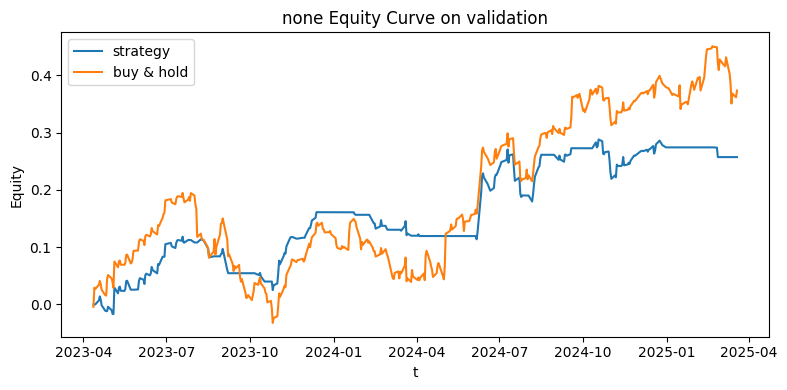

Metrics on validation:
Sharpe ratio: 1.5773895141592496, annual return: 0.24921635879889503, volatility: 0.15799290952667935
[I 2025-07-14 16:40:40,690] Trial 0 finished with value: 1.178937567551143 and parameters: {'window_size': 60, 'num_actions': 11, 'total_timesteps': 500000, 'linear_dim': 73, 'dropout': 0.3129695700716765, 'hidden_dim': 299}. Best is trial 0 with value: 1.178937567551143.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_53


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.97e+03   |
|    ep_rew_mean          | 120        |
| time/                   |            |
|    fps                  | 1569       |
|    iterations           | 100        |
|    time_elapsed         | 240        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.14239281 |
|    clip_fraction        | 0.33       |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.41      |
|    explained_variance   | 0.816      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.315      |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.0437    |
|    value_loss           | 1.14       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.97e+03   |
|    ep_rew_mean

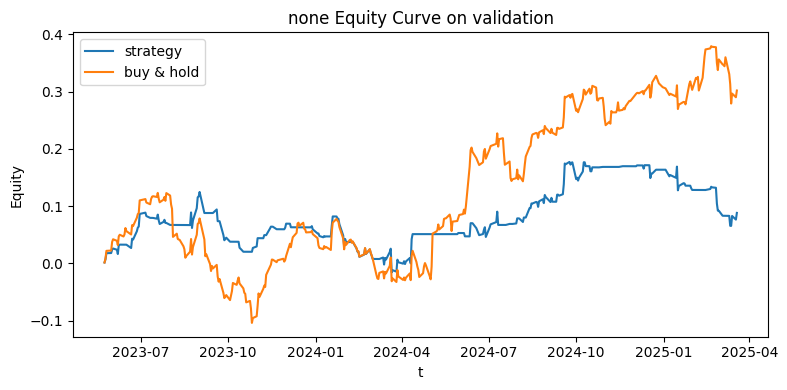

Metrics on validation:
Sharpe ratio: 0.5556213003512012, annual return: 0.09137383451513503, volatility: 0.16445344060312087
[I 2025-07-14 16:51:42,077] Trial 1 finished with value: 0.41634706060038135 and parameters: {'window_size': 90, 'num_actions': 11, 'total_timesteps': 1000000, 'linear_dim': 245, 'dropout': 0.7759424231521916, 'hidden_dim': 426}. Best is trial 0 with value: 1.178937567551143.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_54


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.97e+03   |
|    ep_rew_mean          | 114        |
| time/                   |            |
|    fps                  | 1637       |
|    iterations           | 100        |
|    time_elapsed         | 230        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.06593599 |
|    clip_fraction        | 0.22       |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.49      |
|    explained_variance   | 0.525      |
|    learning_rate        | 0.0003     |
|    loss                 | 24.1       |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.0111    |
|    value_loss           | 33         |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.97e+03   |
|    ep_rew_mean

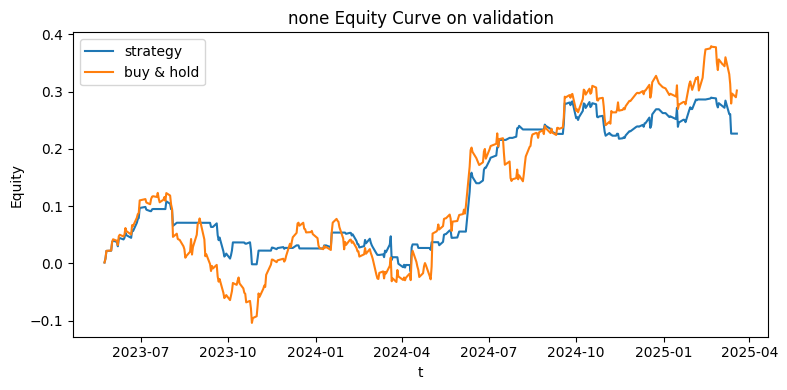

Metrics on validation:
Sharpe ratio: 1.3522849633498002, annual return: 0.23459004546725923, volatility: 0.17347678324112004
[I 2025-07-14 17:12:30,242] Trial 2 finished with value: 1.0169764879850378 and parameters: {'window_size': 90, 'num_actions': 11, 'total_timesteps': 2000000, 'linear_dim': 206, 'dropout': 0.7576492590949324, 'hidden_dim': 465}. Best is trial 0 with value: 1.178937567551143.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_55


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3e+03      |
|    ep_rew_mean          | -5.44      |
| time/                   |            |
|    fps                  | 1871       |
|    iterations           | 100        |
|    time_elapsed         | 201        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.13450631 |
|    clip_fraction        | 0.308      |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.89      |
|    explained_variance   | 0.556      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.228      |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.0579    |
|    value_loss           | 0.741      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3e+03      |
|    ep_rew_mean

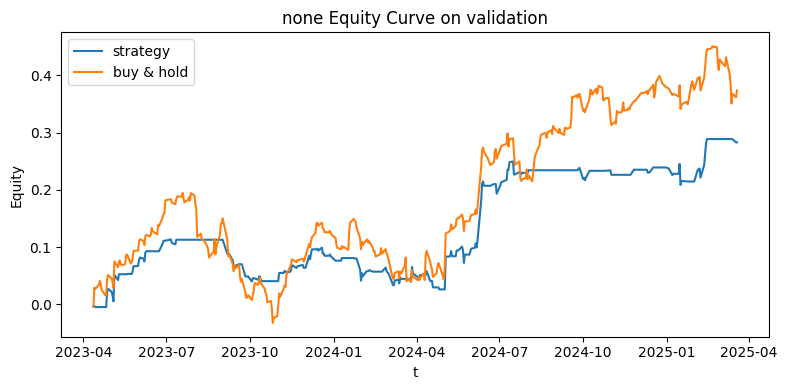

Metrics on validation:
Sharpe ratio: 1.731103959087325, annual return: 0.2741204226924032, volatility: 0.15835006398860377
[I 2025-07-14 17:26:04,664] Trial 3 finished with value: 1.2940088981688485 and parameters: {'window_size': 60, 'num_actions': 19, 'total_timesteps': 1500000, 'linear_dim': 254, 'dropout': 0.6405713385076602, 'hidden_dim': 153}. Best is trial 3 with value: 1.2940088981688485.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_56


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 3e+03      |
|    ep_rew_mean          | -13.3      |
| time/                   |            |
|    fps                  | 2146       |
|    iterations           | 100        |
|    time_elapsed         | 176        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.13138777 |
|    clip_fraction        | 0.269      |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.95      |
|    explained_variance   | 0.643      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.228      |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.0477    |
|    value_loss           | 0.79       |
----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 3e+03     |
|    ep_rew_mean   

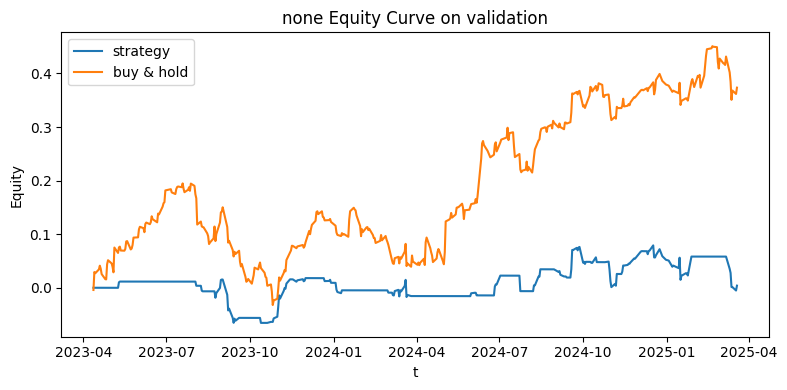

Metrics on validation:
Sharpe ratio: 0.028236583748670444, annual return: 0.0038182050742815356, volatility: 0.1352219201963949
[I 2025-07-14 17:42:03,052] Trial 4 finished with value: 0.02091107014635377 and parameters: {'window_size': 60, 'num_actions': 19, 'total_timesteps': 2000000, 'linear_dim': 175, 'dropout': 0.7210489198034287, 'hidden_dim': 276}. Best is trial 3 with value: 1.2940088981688485.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_57


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.86e+03   |
|    ep_rew_mean          | 77.4       |
| time/                   |            |
|    fps                  | 1549       |
|    iterations           | 100        |
|    time_elapsed         | 243        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.19297819 |
|    clip_fraction        | 0.268      |
|    clip_range           | 0.25       |
|    entropy_loss         | -0.72      |
|    explained_variance   | 0.694      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.453      |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.0079    |
|    value_loss           | 1.82       |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.86e+03   |
|    ep_rew_mean

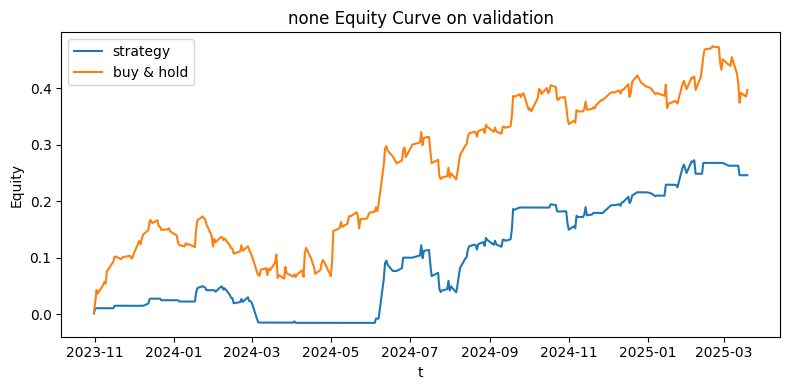

Metrics on validation:
Sharpe ratio: 1.985369982456854, annual return: 0.33670158710374515, volatility: 0.1695913558071851
[I 2025-07-14 18:04:23,094] Trial 5 finished with value: 1.4907694638509212 and parameters: {'window_size': 200, 'num_actions': 5, 'total_timesteps': 2000000, 'linear_dim': 88, 'dropout': 0.3872680461249408, 'hidden_dim': 403}. Best is trial 5 with value: 1.4907694638509212.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_58


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.86e+03   |
|    ep_rew_mean          | 67.3       |
| time/                   |            |
|    fps                  | 1672       |
|    iterations           | 100        |
|    time_elapsed         | 226        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.19273657 |
|    clip_fraction        | 0.306      |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.25      |
|    explained_variance   | 0.422      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.231      |
|    n_updates            | 1584       |
|    policy_gradient_loss | 0.00618    |
|    value_loss           | 17         |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.86e+03   |
|    ep_rew_mean

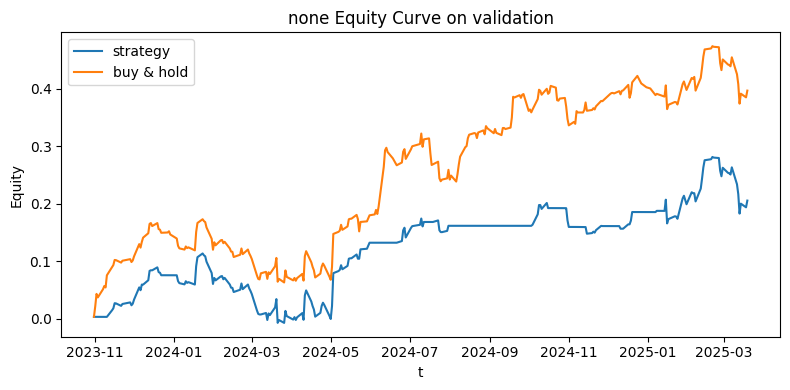

Metrics on validation:
Sharpe ratio: 1.405723512724308, annual return: 0.2812187609453409, volatility: 0.2000526834756685
[I 2025-07-14 18:19:41,137] Trial 6 finished with value: 1.0683720871906177 and parameters: {'window_size': 200, 'num_actions': 11, 'total_timesteps': 1500000, 'linear_dim': 56, 'dropout': 0.2595546137793592, 'hidden_dim': 255}. Best is trial 5 with value: 1.4907694638509212.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_59


Output()

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 3e+03       |
|    ep_rew_mean          | -15.7       |
| time/                   |             |
|    fps                  | 2503        |
|    iterations           | 100         |
|    time_elapsed         | 150         |
|    total_timesteps      | 378000      |
| train/                  |             |
|    approx_kl            | 0.075124145 |
|    clip_fraction        | 0.22        |
|    clip_range           | 0.25        |
|    entropy_loss         | -1.99       |
|    explained_variance   | 0.459       |
|    learning_rate        | 0.0003      |
|    loss                 | 0.411       |
|    n_updates            | 1584        |
|    policy_gradient_loss | -0.0271     |
|    value_loss           | 1.01        |
-----------------------------------------
---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 3e+03     

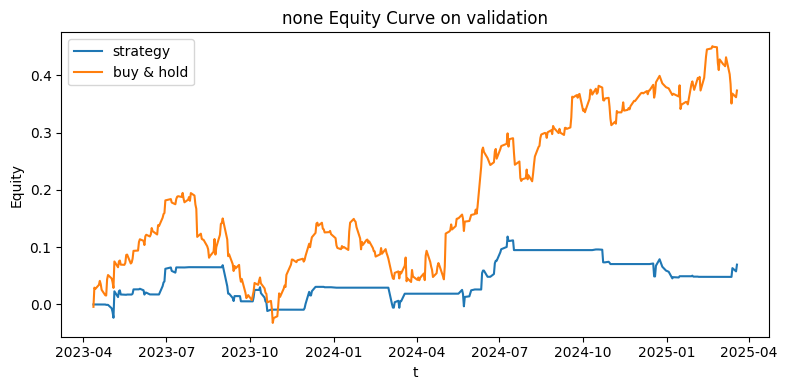

Metrics on validation:
Sharpe ratio: 0.5880777133877058, annual return: 0.06734871294831306, volatility: 0.11452349139426006
[I 2025-07-14 18:29:58,566] Trial 7 finished with value: 0.43185901325588794 and parameters: {'window_size': 60, 'num_actions': 19, 'total_timesteps': 1500000, 'linear_dim': 88, 'dropout': 0.4480739541246699, 'hidden_dim': 199}. Best is trial 5 with value: 1.4907694638509212.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_60


Output()

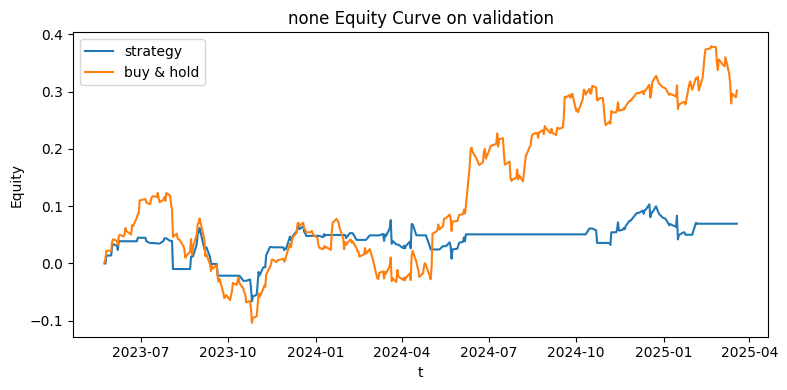

Metrics on validation:
Sharpe ratio: 0.466574960916059, annual return: 0.0718483792289997, volatility: 0.15399107377715854
[I 2025-07-14 18:32:11,034] Trial 8 finished with value: 0.3481569864099412 and parameters: {'window_size': 90, 'num_actions': 5, 'total_timesteps': 200000, 'linear_dim': 195, 'dropout': 0.3574481929034773, 'hidden_dim': 347}. Best is trial 5 with value: 1.4907694638509212.
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_61


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.94e+03   |
|    ep_rew_mean          | 135        |
| time/                   |            |
|    fps                  | 1789       |
|    iterations           | 100        |
|    time_elapsed         | 211        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.12998192 |
|    clip_fraction        | 0.287      |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.77      |
|    explained_variance   | 0.527      |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0179     |
|    n_updates            | 1584       |
|    policy_gradient_loss | -0.0442    |
|    value_loss           | 0.404      |
----------------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.94e+03   |
|    ep_rew_mean

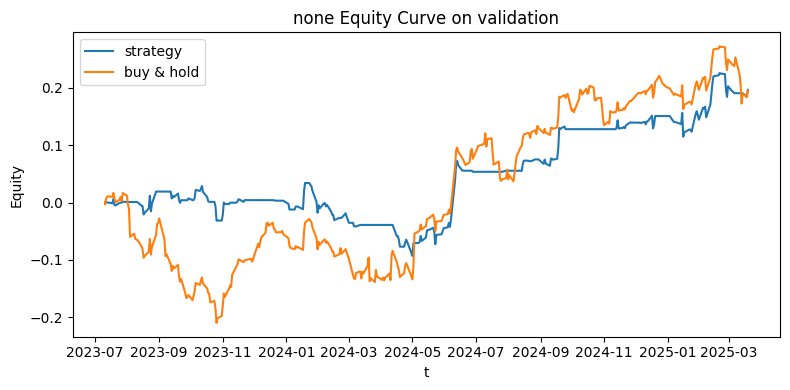

Metrics on validation:
Sharpe ratio: 1.2611387229162243, annual return: 0.21781735540078256, volatility: 0.1727148262461622
[I 2025-07-14 18:51:33,480] Trial 9 finished with value: 0.9481423126615918 and parameters: {'window_size': 120, 'num_actions': 19, 'total_timesteps': 2000000, 'linear_dim': 119, 'dropout': 0.7557109921157142, 'hidden_dim': 125}. Best is trial 5 with value: 1.4907694638509212.
Лучшие параметры: {'window_size': 200, 'num_actions': 5, 'total_timesteps': 2000000, 'linear_dim': 88, 'dropout': 0.3872680461249408, 'hidden_dim': 403}
Лучшая награда: 1.4907694638509212


In [13]:
if CONFIG["optuna"]["n_trials"] > 0:
    # Оптимизация гиперпараметров с Optuna
    study = optuna.create_study(
        direction=CONFIG["optuna"]["direction"],
        sampler=TPESampler(seed=CONFIG["seed"])
    )

    study.optimize(
        objective,
        n_trials=CONFIG["optuna"]["n_trials"],
        timeout=CONFIG["optuna"]["timeout"],
        show_progress_bar=True
    )

    best_params = study.best_params
    
    with open("best_params.yaml", "w") as f:
        yaml.dump(best_params, f)
        
    print(f"Лучшие параметры: {best_params}")
    print(f"Лучшая награда: {study.best_value}")
else:
    # Простое обучение без оптимизации
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)

# Тест модели при обучении сразу же на нескольких активах

In [12]:
CONFIG['total_timesteps'] = 300000

In [13]:
def train_single_model_3assets(config, trial=None):
    set_seeds(config["seed"])
    
    first_asset = 'AAPL'
    raw_data, scaled_data, time_data, _ = prepare_aligned_data(
        first_asset, config
    )
    dummy_env = create_env(
        raw_data, scaled_data, time_data, config,
        mode='train', n_envs=5
    )

    policy_kwargs = get_model_config(config["model_type"])
    
    ppo_params = config["ppo_params"].copy()
    ppo_params["policy_kwargs"] = policy_kwargs

    model = PPO(
        "MlpPolicy",
        dummy_env,
        verbose=1,
        **ppo_params
    )
    
    # Обучаем последовательно на всех активах
    assets = ['AAPL', 'AMZN', 'MSFT']
    for asset in assets:
        raw_data, scaled_data, time_data, _ = prepare_aligned_data(
            asset, config
        )
        
        # Создаем train окружение для текущего актива
        env_train = create_env(
            raw_data, scaled_data, time_data, config,
            mode='train', n_envs=5
        )
        
        # Устанавливаем новое окружение для модели
        model.set_env(env_train)
        
        # Продолжаем обучение на текущем активе
        model.learn(
            total_timesteps=config["total_timesteps"], 
            log_interval=100, 
            callback=ProgressBarCallback(),
            reset_num_timesteps=False  # Не сбрасываем счетчик шагов
        )
    
    # Тестируем на валидационных данных каждого актива
    all_metrics = {}
    for asset in assets:
        raw_data, scaled_data, time_data, _ = prepare_aligned_data(
            asset, config
        )
        env_val = create_env(
            raw_data, scaled_data, time_data, config,
            mode='val', n_envs=1
        )
        returns, b_h_ret = daily_portfolio_return(env_val, model)
        metrics = statistics_calc(
            returns, 
            b_h_ret, 
            name=asset, 
            plot=True, 
            mode='validation'
        )
        all_metrics[asset] = metrics
    
    return all_metrics, model

Режим обучения: единый прогон
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Shape of data: (4040, 6) 2010-01-04 00:00:00
Logging to logs/PPO_62


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00
Logging to logs/PPO_62


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00
Logging to logs/PPO_62


Output()

Shape of data: (4040, 6) 2010-01-04 00:00:00


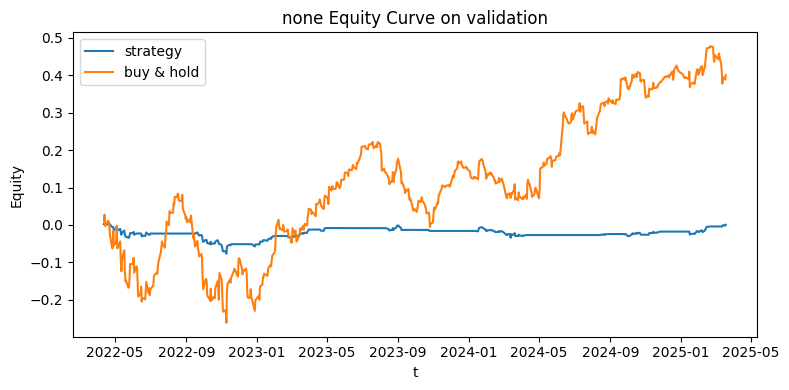

Metrics on validation:
Sharpe ratio: 0.006508049598630384, annual return: 0.0003054950492295322, volatility: 0.04694110648662289
Shape of data: (4040, 6) 2010-01-04 00:00:00


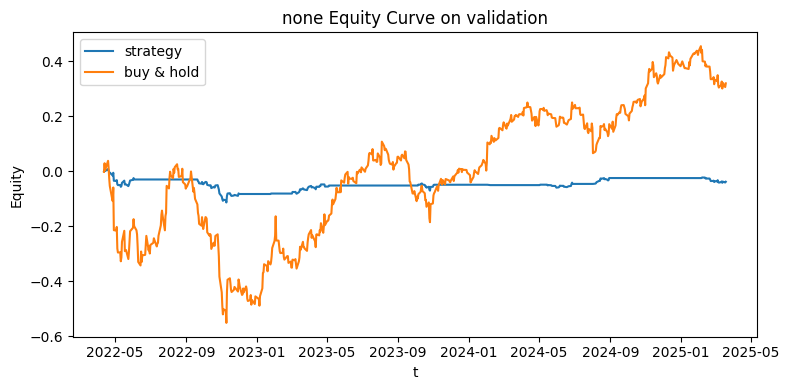

Metrics on validation:
Sharpe ratio: -0.4020133097141034, annual return: -0.02443692699690771, volatility: 0.060786363054214115
Shape of data: (4040, 6) 2010-01-04 00:00:00


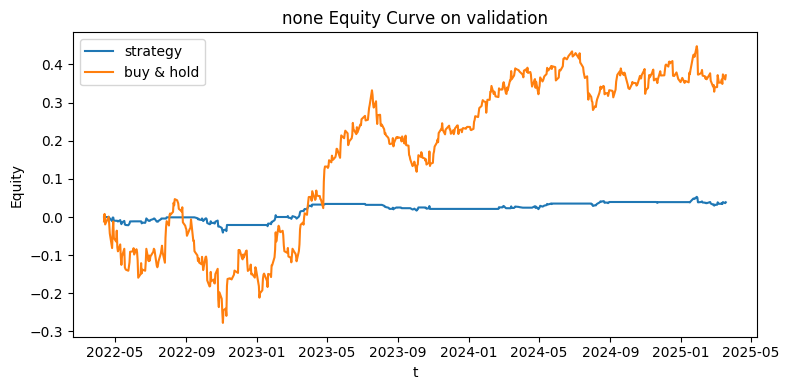

Metrics on validation:
Sharpe ratio: 0.5437368231855066, annual return: 0.02462736141063486, volatility: 0.04529279673639603


In [14]:
if CONFIG["training_mode"] == "single":
    print("Режим обучения: единый прогон")
    all_metrics, model = train_single_model_3assets(CONFIG)
elif CONFIG["training_mode"] == "sliding_window":
    print("Режим обучения: скользящие окна")
    results = sliding_window_training(CONFIG)
    print(results)
else:
    raise ValueError("Неизвестный режим обучения")

Режим обучения: единый прогон
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Shape of data: (4040, 6) 2010-01-04 00:00:00
Logging to logs/PPO_62


Output()

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 2.75e+03   |
|    ep_rew_mean          | -1.38      |
| time/                   |            |
|    fps                  | 1612       |
|    iterations           | 100        |
|    time_elapsed         | 234        |
|    total_timesteps      | 378000     |
| train/                  |            |
|    approx_kl            | 0.23987325 |
|    clip_fraction        | 0.155      |
|    clip_range           | 0.25       |
|    entropy_loss         | -1.5       |
|    explained_variance   | 0.046      |
|    learning_rate        | 0.0003     |
|    loss                 | 92.1       |
|    n_updates            | 1584       |
|    policy_gradient_loss | 0.039      |
|    value_loss           | 262        |
----------------------------------------


Shape of data: (4040, 6) 2010-01-04 00:00:00
Logging to logs/PPO_62


Output()

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.75e+03    |
|    ep_rew_mean          | 49.1        |
| time/                   |             |
|    fps                  | 1582        |
|    iterations           | 100         |
|    time_elapsed         | 238         |
|    total_timesteps      | 880740      |
| train/                  |             |
|    approx_kl            | 0.045355294 |
|    clip_fraction        | 0.0951      |
|    clip_range           | 0.25        |
|    entropy_loss         | -1.71       |
|    explained_variance   | 0.488       |
|    learning_rate        | 0.0003      |
|    loss                 | 14.5        |
|    n_updates            | 3712        |
|    policy_gradient_loss | 0.0159      |
|    value_loss           | 17.7        |
-----------------------------------------


Shape of data: (4040, 6) 2010-01-04 00:00:00
Logging to logs/PPO_62


Output()

-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 2.75e+03    |
|    ep_rew_mean          | 37.8        |
| time/                   |             |
|    fps                  | 1577        |
|    iterations           | 100         |
|    time_elapsed         | 239         |
|    total_timesteps      | 1383480     |
| train/                  |             |
|    approx_kl            | 0.047867615 |
|    clip_fraction        | 0.0603      |
|    clip_range           | 0.25        |
|    entropy_loss         | -1.67       |
|    explained_variance   | 0.0757      |
|    learning_rate        | 0.0003      |
|    loss                 | 22.9        |
|    n_updates            | 5840        |
|    policy_gradient_loss | 0.00988     |
|    value_loss           | 34.7        |
-----------------------------------------


Shape of data: (4040, 6) 2010-01-04 00:00:00


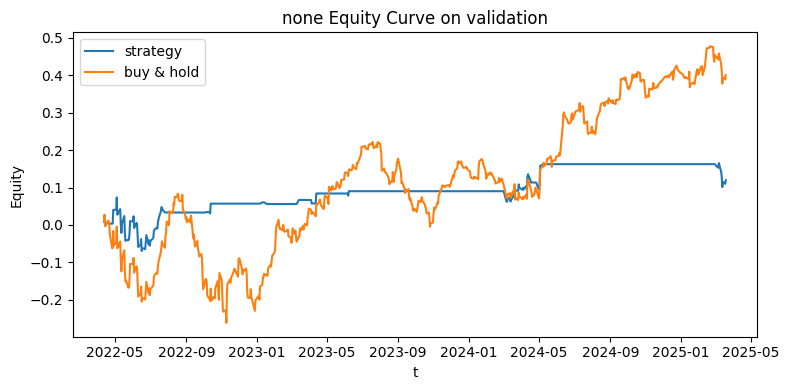

Metrics on validation:
Sharpe ratio: 0.5471955563041445, annual return: 0.07599116584130679, volatility: 0.13887387235847556
Shape of data: (4040, 6) 2010-01-04 00:00:00


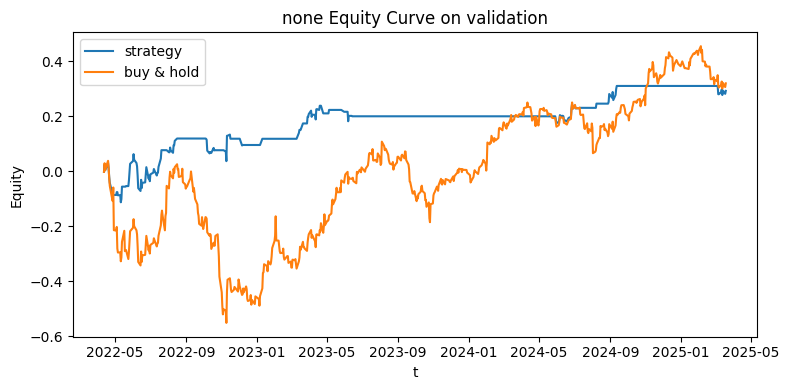

Metrics on validation:
Sharpe ratio: 0.9893212773036723, annual return: 0.18608629473421914, volatility: 0.18809490809839313
Shape of data: (4040, 6) 2010-01-04 00:00:00


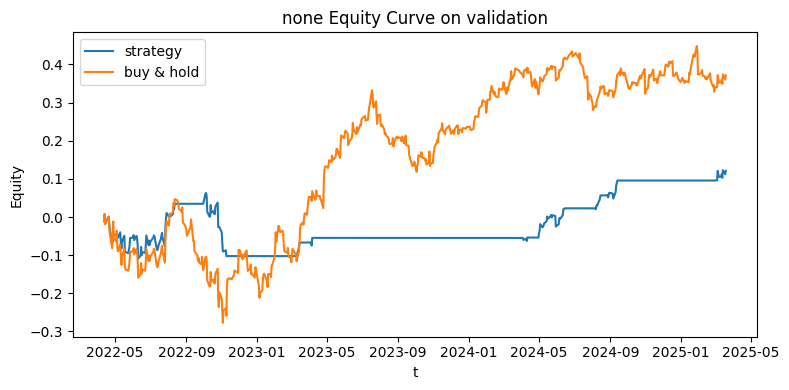

Metrics on validation:
Sharpe ratio: 0.5142642343379742, annual return: 0.07704643495834046, volatility: 0.14981876983439138


In [15]:
CONFIG['total_timesteps'] = 500000
if CONFIG["training_mode"] == "single":
    print("Режим обучения: единый прогон")
    all_metrics, model = train_single_model_3assets(CONFIG)
elif CONFIG["training_mode"] == "sliding_window":
    print("Режим обучения: скользящие окна")
    results = sliding_window_training(CONFIG)
    print(results)
else:
    raise ValueError("Неизвестный режим обучения")

In [15]:
CONFIG = {
    "ticker": "MSFT",
    "model_type": "Linear",
    "window_size": 90,
    "price_column": 3,
    "num_actions": 11,
    "training_mode": "single",
    "sliding_window_config": {
        "train_years": 5,
        "val_years": 1,
        "test_years": 1,
        "start_year": 2010,
        "n_windows": 5,
        "n_envs": 1,
        "n_agents": 3
    },
    "seed": 42,
    "ppo_params": {
        "n_steps": 756,
        "batch_size": 1260,
        "n_epochs": 16,
        "gamma": 0.9,
        "gae_lambda": 0.9,
        "clip_range": 0.25,
        "learning_rate": 3e-4,
        "ent_coef": 0.01,
        "vf_coef": 0.5,
        "max_grad_norm": 0.5,
        "tensorboard_log": "logs/"
    },
    "total_timesteps": 500000,
    # Периоды для одиночного режима
    "train_period": ("2010-11-13", "2024-01-11"),
    "val_period": ("2024-01-11", "2025-03-19"),
    "test_period": None  # Для одиночного режима
}


Режим обучения: единый прогон
Shape of data: (4040, 6) 2010-01-04 00:00:00
Using cpu device
Logging to logs/PPO_67


Output()

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 3.22e+03  |
|    ep_rew_mean          | -15.6     |
| time/                   |           |
|    fps                  | 2289      |
|    iterations           | 100       |
|    time_elapsed         | 165       |
|    total_timesteps      | 378000    |
| train/                  |           |
|    approx_kl            | 0.1069263 |
|    clip_fraction        | 0.214     |
|    clip_range           | 0.25      |
|    entropy_loss         | -1.49     |
|    explained_variance   | 0.413     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.458     |
|    n_updates            | 1584      |
|    policy_gradient_loss | 0.0223    |
|    value_loss           | 1.63      |
---------------------------------------


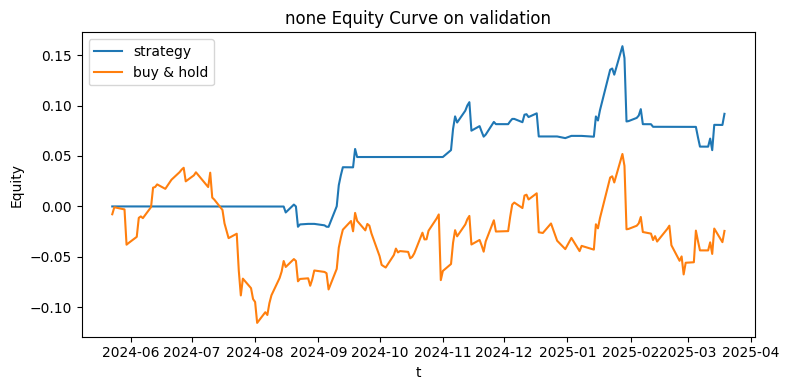

Metrics on validation:
Sharpe ratio: 1.238116635289553, annual return: 0.21483847402034872, volatility: 0.17352038402270992


In [16]:
if CONFIG["training_mode"] == "single":
    print("Режим обучения: единый прогон")
    metrics, ret_cur, b_h_ret_cur, model = train_single_model(CONFIG)
elif CONFIG["training_mode"] == "sliding_window":
    print("Режим обучения: скользящие окна")
    results = sliding_window_training(CONFIG)
    print(results)
else:
    raise ValueError("Неизвестный режим обучения")